In [1]:
%matplotlib widget
import jungfrau_utils as ju
import numpy as np
import json, h5py
import os, glob
import time
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib import cm
from scipy.optimize import curve_fit
from textwrap import wrap
from IPython.display import clear_output, display
import matplotlib.colors as colors
import matplotlib.ticker as ticker
from ipyfilechooser import FileChooser
from scipy.stats.stats import pearsonr
import pickle

from alvra_tools.load_data import *
from alvra_tools.channels import *
from alvra_tools.utils import *
from alvra_tools.XES_functions import *
from sfdata import SFScanInfo

import warnings
warnings.filterwarnings('ignore')

# Table of Contents: 
* [Load stacked data](#Load_data)
* [Energy calibration](#energy_calib)
* [Kb model fit](#model_fit)



<a id='Load_data'></a>
## Load data

In [2]:
pgroup = 'p20222'
firstrun = 485
Loaddir = '../Claudio/Reduced_XES_timescans_TT_rot/_stacks/run0485-FebpyCN4_DMAwater_1_2ps_4uJ_short_001_stack_40_runs/'

########################################################################

run2load = Loaddir.split('/')[-2]
datafile = glob.glob('/sf/alvra/data/{}/work/reduced_data/*{:04d}*/meta/scan.json'.format(pgroup, firstrun))[0]
scan = SFScanInfo(datafile)
titlestring_stack = run2load
savedir = '../Claudio/PNG/'+run2load #+'_rot'
run_array = np.load(Loaddir + 'run_array.npy', allow_pickle=True).item()
for key in run_array.keys():
    s_all_off = run_array[key]["all_spectra_shots_off"]
    s_all_on  = run_array[key]["all_spectra_shots_on"]
    ROIs      = run_array[key]["ROIs"]
    all_delays_fs_scan = run_array[key]["all_delays_fs_scan"]
    all_delays_corr_scan = run_array[key]["all_delays_corr_scan"]
    meta = run_array[key]["meta"]
    if len(run_array[key]["runlist"]) != 0:        
        runlist = run_array[key]["runlist"]
        titlestring_stack = pgroup + ' --- ' +str(runlist)
try:
    with open(Loaddir+'calibration.pkl', 'rb') as f:
        calibration = pickle.load(f)
except:
    print ('No energy calibration file found!')

### Merge ROIs

In [345]:
ROIs

['JF02T09V03:ROI_KaDW',
 'JF02T09V03:ROI_KaDW_bkg',
 'JF02T09V03:ROI_KaUP',
 'JF02T09V03:ROI_KaUP_bkg',
 'JF02T09V03:ROI_KbDW',
 'JF02T09V03:ROI_KbDW_bkg',
 'JF02T09V03:ROI_KbUP',
 'JF02T09V03:ROI_KbUP_bkg']

In [343]:
energy_axis = {}
s_all_off_merged = {}
s_all_on_merged = {}

In [ ]:
ROI2merge = 'Kb'

temp_merged_off = []
temp_merged_on  = []
for ROI in ROIs:
    if "bkg" in ROI:
        continue
    if ROI2merge in ROI:
        print (ROI)
        ROI_size = np.array(meta[ROI+'-roi'])[1][1]-np.array(meta[ROI+'-roi'])[1][0]
        yaxis = np.arange(np.array(meta[ROI+'-roi']).flatten()[-2], np.array(meta[ROI+'-roi']).flatten()[-1], 1)
        (m,b) = calibration[ROI]
        energy_axis[ROI2merge] = m*yaxis[1:] + b
        temp_merged_off += list(np.array(s_all_off[ROI])[:,1:ROI_size])
        temp_merged_on  += list(np.array(s_all_on[ROI])[:,1:ROI_size])
        s_all_off_merged[ROI2merge] = temp_merged_off
        s_all_on_merged[ROI2merge]  = temp_merged_on



In [307]:
common_energy2 = energy_axis[key]

for key in energy_axis.keys():
    common_energy2 = np.copy()
    delta_E = energy_axis[key][-1]-energy_axis[key][1]
    temp = np.interp(common_energy2, energy_axis[key], np.average(s_all_on_merged[key], axis=0), period=delta_E)

NameError: name 'common_energy2' is not defined

In [304]:
np.shape(energy_axis['Kb'])

(139,)

KeyError: 'Kb'

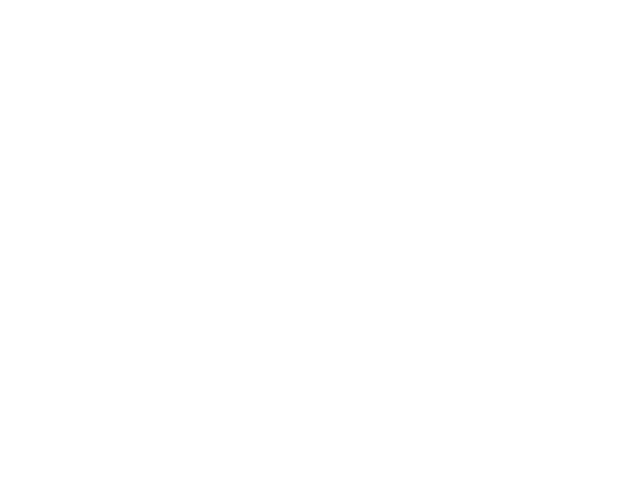

In [219]:
ROI = 'JF02T09V03:ROI_KbDW'

ROI_size = np.array(meta[ROI+'-roi'])[1][1]-np.array(meta[ROI+'-roi'])[1][0]

plt.figure()
plt.plot(energy_axis['Kb'], np.average(s_all_off[ROI], axis=0)[:ROI_size])
plt.show()

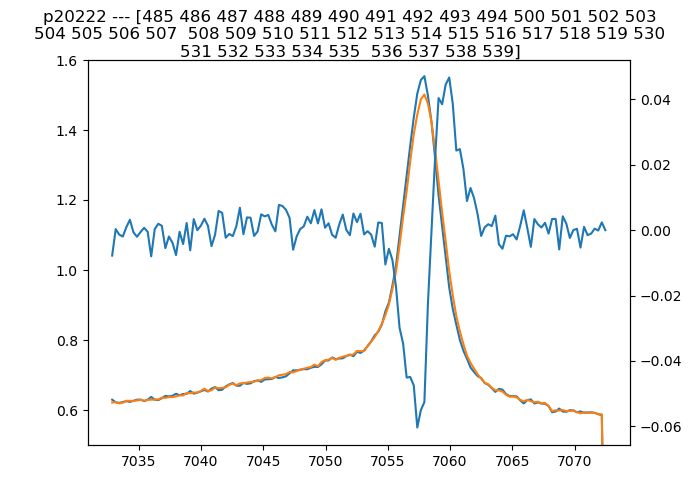

In [3]:
ROI = 'JF02T09V03:ROI_KbDW'

ROI_size = np.array(meta[ROI+'-roi'])[1][1]-np.array(meta[ROI+'-roi'])[1][0]
yaxis = np.arange(np.array(meta[ROI+'-roi']).flatten()[-2], np.array(meta[ROI+'-roi']).flatten()[-1], 1)
(m,b) = calibration[ROI]
y_axis_rebin = m*yaxis + b
ylabel = 'Emission energy (eV)'

fig = plt.figure(figsize = (7,5))
fig.suptitle("\n".join(wrap(titlestring_stack)))
ax1 = fig.add_subplot(111)
ax2 = plt.twinx(ax1)

ax1.plot(y_axis_rebin, np.average(s_all_off[ROI], axis=0)[:ROI_size])
ax1.plot(y_axis_rebin, np.average(s_all_on[ROI], axis=0)[:ROI_size])
ax2.plot(y_axis_rebin, np.average(s_all_on[ROI], axis=0)[:ROI_size]-np.average(s_all_off[ROI], axis=0)[:ROI_size])
ax1.set_ylim(0.5,1.6)

plt.show()
         


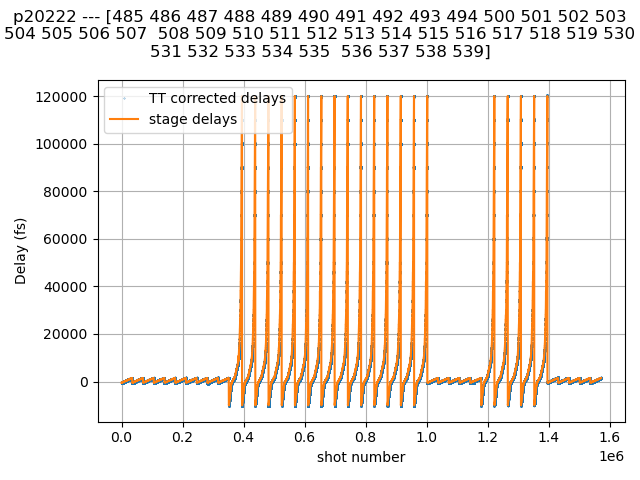

In [4]:
plt.figure()
plt.suptitle("\n".join(wrap(titlestring_stack)))
plt.plot(all_delays_corr_scan, '.',ms=0.5, label = 'TT corrected delays')
plt.plot(all_delays_fs_scan, label = 'stage delays')
plt.xlabel('shot number')
plt.ylabel('Delay (fs)')
plt.legend (loc='best')
plt.tight_layout()
plt.grid()
plt.show()

os.makedirs(savedir, exist_ok=True)
#plt.savefig(savedir + '/' + 'scans_summary.png')

### variable binsize...

In [12]:
numbins = 150

#all_chosen_delays = np.array(all_delays_corr_scan)
all_chosen_delays = np.array(all_delays_fs_scan)

#####################################################################################################
def histedges_equalN(x, nbin):
    npt = len(x)
    return np.interp(np.linspace(0, npt, nbin),
                     np.arange(npt),
                     np.sort(x))

binList = histedges_equalN(all_chosen_delays, numbins)

bin_centres = (binList[:-1] + binList[1:])/2
all_Delay_fs_TT = np.copy(bin_centres)


### ... or fix binsize with a range

In [10]:
binsize = 50

min_delay = -5000
max_delay = 50000

############################################_stacks#########################################################

#binList = np.arange(all_delays_fs_scan[0]-10, all_delays_fs_scan[-1]+10, binsize)
#all_Delay_fs_TT = np.arange(all_delays_fs_scan[0]-10 + binsize/2, all_delays_fs_scan[-1]+10 - binsize/2, binsize)

binList = np.arange(min_delay, max_delay, binsize)
bin_centres = (binList[:-1] + binList[1:])/2
all_Delay_fs_TT = np.arange(min_delay + binsize/2, max_delay - binsize/2, binsize)
#all_Delay_fs_TT = np.arange(min_delay, max_delay, binsize)


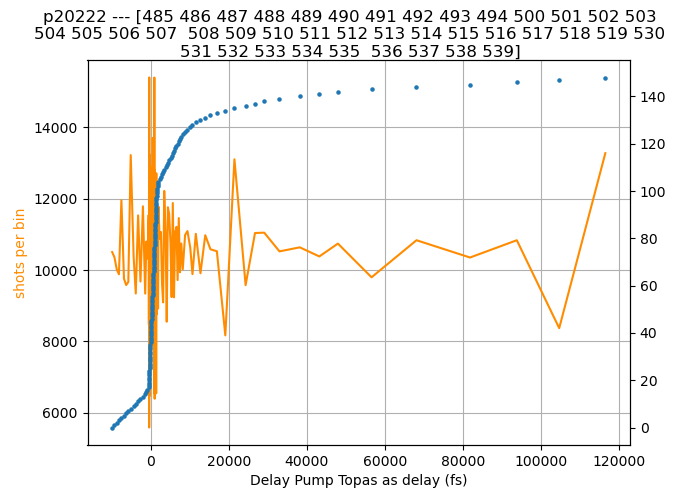

In [13]:
all_s_rebin_on = {}
all_s_rebin_off = {}

for j,ROI in enumerate(ROIs):
    ROI_size = np.array(meta[ROI+'-roi'])[1][1]-np.array(meta[ROI+'-roi'])[1][0]
    
    temp_s_on  = np.array(s_all_on[ROI])[:,:ROI_size]
    temp_s_off  = np.array(s_all_off[ROI])[:,:ROI_size]
    
    all_spec_rebin_on   = np.zeros((len(bin_centres), ROI_size)) 
    all_spec_rebin_off  = np.zeros((len(bin_centres), ROI_size))
    howmany = []
    for i in range(len(bin_centres)):
        specs_off_per_bin = len(temp_s_off) // len(bin_centres)
        cond1 = all_chosen_delays >= binList[i]
        cond2 = all_chosen_delays < binList[i+1]

        idx = np.where(cond1*cond2)[0]
        all_Delay_fs_TT[i] = np.average(all_chosen_delays[idx])
        howmany.append(len(idx))
        
        all_spec_rebin_on[i]  = np.average(temp_s_on[idx,:], axis=0)
        all_spec_rebin_off[i] = np.average(temp_s_off[i*specs_off_per_bin:specs_off_per_bin*(i+1),:], axis=0)
        
    all_s_rebin_on[ROI]   = all_spec_rebin_on
    all_s_rebin_off[ROI]  = all_spec_rebin_off

fig = plt.figure(figsize = (7,5))
fig.suptitle("\n".join(wrap(titlestring_stack)))
ax1 = fig.add_subplot(111)
ax2 = plt.twinx(ax1)

delayrange = np.arange(0, len(all_Delay_fs_TT), 1)
ax1.plot(all_Delay_fs_TT, np.array(howmany), color = 'darkorange')
ax2.scatter(all_Delay_fs_TT, delayrange, s = 5)

ax1.set_xlabel('{} ({})'.format(scan.parameters['name'][0], scan.parameters['units'][0]))
ax1.set_ylabel('shots per bin', color='darkorange')
ax1.grid()
plt.show()

os.makedirs(savedir, exist_ok=True)
#plt.savefig(savedir + '/' + 'bins_population.png')

In [11]:
len(all_chosen_delays)

1571985

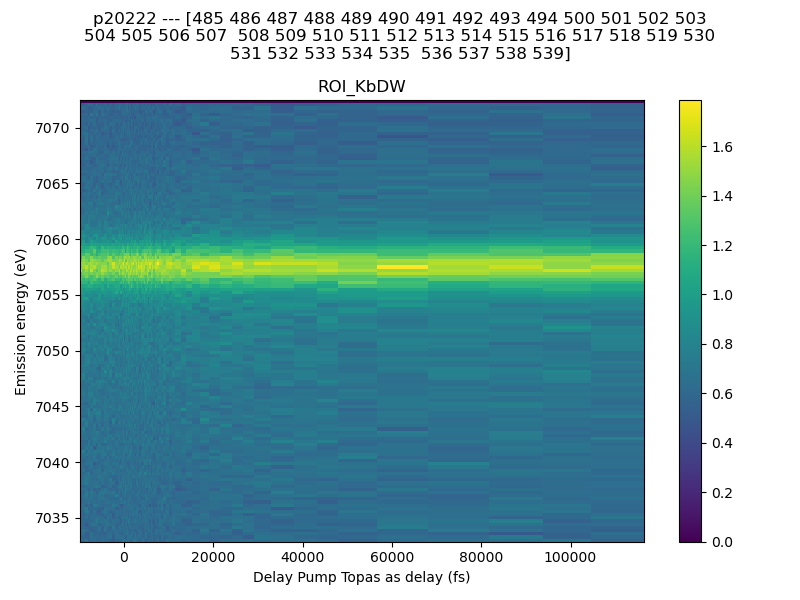

In [30]:
ROI = 'JF02T09V03:ROI_KbDW'

energy_calib = True

#m = -0.47857422907729574
#b = 8845.127599211164

bin_ = 1

vmin = None
vmax = None

##########################################################
ROI_size = np.array(meta[ROI+'-roi'])[1][1]-np.array(meta[ROI+'-roi'])[1][0]
plt.figure(figsize=(8,6))
plt.suptitle("\n".join(wrap(titlestring_stack)))

all_Delay_fs_TT_noNans = np.copy(all_Delay_fs_TT)
all_Delay_fs_TT_noNans = all_Delay_fs_TT_noNans[~np.isnan(all_Delay_fs_TT)]

matrix_on = all_s_rebin_on[ROI]
matrix_on = matrix_on[~np.isnan(all_Delay_fs_TT),:]

matrix_off = np.asarray(s_all_off[ROI])[:,:ROI_size]
matrix_off2 = np.asarray(all_s_rebin_off[ROI])[:,:ROI_size]
#matrix_off = matrix_off[~np.isnan(all_Delay_fs_TT),:]

yaxis = np.arange(np.array(meta[ROI+'-roi']).flatten()[-2], np.array(meta[ROI+'-roi']).flatten()[-1], 1)
y_axis_rebin, matrix_on_rebin = plot_tool_static_2D(matrix_on, 0, yaxis, bin_)
y_axis_rebin, matrix_off_rebin = plot_tool_static_2D(matrix_off, 0, yaxis, bin_)
y_axis_rebin, matrix_off_rebin2 = plot_tool_static_2D(matrix_off2, 0, yaxis, bin_)

y_label = 'JF pixel'
if energy_calib:
    (m,b) = calibration[ROI]
    y_axis_rebin = m*y_axis_rebin + b
    ylabel = 'Emission energy (eV)'

plt.title(ROI.split(':')[-1])
pp_2D  = np.transpose(np.asarray(matrix_on_rebin) - np.average(np.asarray(matrix_off_rebin), axis=0))
on_2D  = np.transpose(np.asarray(matrix_on_rebin))
off_2D = np.transpose(np.asarray(matrix_off_rebin2))

plt.pcolormesh(all_Delay_fs_TT_noNans, y_axis_rebin, off_2D, vmin = vmin, vmax = vmax)

plt.colorbar()
plt.ylabel(ylabel)
#plt.ylim(7054, 7062)
#plt.axhline(y = 5095-15, color = 'r', linestyle = '-')
#plt.axhline(y = 5095+15, color = 'r', linestyle = '-')
#plt.axvline(x = 2.55, color = 'r', linestyle = '-')

plt.xlabel('{} ({})'.format(scan.parameters['name'][0], scan.parameters['units'][0]))
plt.tight_layout()
plt.show()

os.makedirs(savedir, exist_ok=True)
#plt.savefig(savedir + '/' + 'stack_{}_variable_OFF.png'.format(ROI.split(':')[-1]))

In [31]:
chosen_point = 7055
#index_pixel = np.arange(len(y_axis_rebin))[(y_axis_rebin > chosen_pixel)][0]
index_point = np.int(np.argwhere(y_axis_rebin < chosen_point)[0])
index_point

62

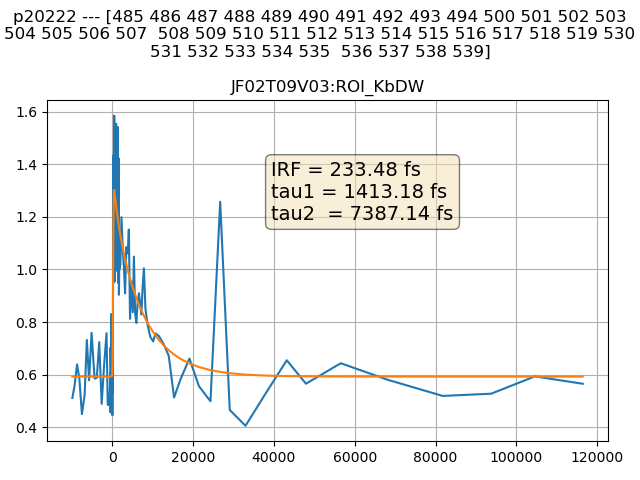

In [32]:
pp_int = np.sum(np.abs(pp_2D[index_point-15:index_point+15,:]), axis = 0)

##    x0, sigma, amp1, tau1, C,   amp2, tau2
p0 = [0,  200,   1,    1000, 1, 1,    10000]

popt,_  = curve_fit(model_decay_2exp, all_Delay_fs_TT_noNans, pp_int, p0=p0, maxfev=40000)
y_fit = model_decay_2exp(all_Delay_fs_TT_noNans, *popt)


fig, ax = plt.subplots(constrained_layout=True)
plt.suptitle("\n".join(wrap(titlestring_stack)))
plt.title(ROI)
plt.plot(all_Delay_fs_TT_noNans, pp_int)
plt.plot(all_Delay_fs_TT_noNans, y_fit)


boxstyle = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
boxtext = '\n'.join((r'IRF = {:.2f} fs'.format(np.abs(popt[1]*2.3548)),
                     r'tau1 = {:.2f} fs'.format(np.abs(popt[3])),
                     r'tau2  = {:.2f} fs'.format(np.abs(popt[6]))))
plt.text(0.4, 0.65, boxtext, transform=ax.transAxes, bbox=boxstyle, fontsize=14)

plt.grid()
plt.tight_layout()
#plt.ylim(-0.25, 2)
plt.show()

os.makedirs(savedir, exist_ok=True)
#plt.savefig(savedir + '/{}.png'.format(ROI.split(':')[-1]))

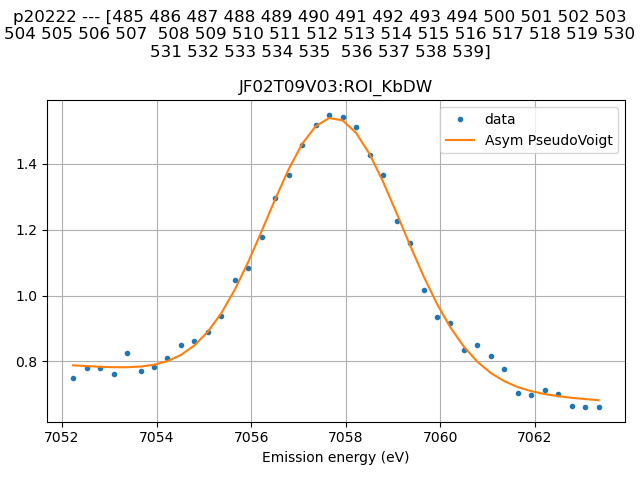

8.712224744468841
7057.629460109719


In [33]:
linewidth = 40 ## in pixels

######################################################################
from scipy.optimize import curve_fit
from lmfit.models import PseudoVoigtModel, VoigtModel, LorentzianModel
mod = PseudoVoigtModel()

line = on_2D[:,0]

#center2 = y_axis_rebin[(np.argmax(line))]
center = np.argmax(line)
liminf = center-np.int(linewidth/2)
limsup = center+np.int(linewidth/2)

line2fit = line[liminf:limsup]# - np.average(line[0:10])
axis2fit = y_axis_rebin[liminf:limsup] 

p0     = [y_axis_rebin[center], 4, 3, 0.5, -0.5, -0.0001, 0.1]
# p0_min = [0, 0, -1000, 0, -np.inf, -np.inf] # minimum bounds for each parameter16
# p0_max = [1, 1, 1000, 1, np.inf, np.inf] # maximum bounds for each parameter
# bounds = (p0_min, p0_max)

popt, pcov = curve_fit(AsymPseudoVoigt, axis2fit, line2fit, p0=p0, maxfev=40000)
y_fit = AsymPseudoVoigt(axis2fit, *popt)

pars = mod.guess(line2fit, x=axis2fit)
init = mod.eval(pars, x=axis2fit)
out = mod.fit(line2fit, center=y_axis_rebin[center], x=axis2fit)
    
plt.figure()
plt.suptitle("\n".join(wrap(titlestring_stack)))
plt.title(ROI)
plt.plot(axis2fit, line2fit,'.', label = 'data')
#plt.plot(axis2fit, out.best_fit, label = 'pseudoVoigt')
plt.plot(axis2fit, y_fit, label ='Asym PseudoVoigt')

plt.grid()
plt.xlabel(ylabel)
plt.legend(loc='best')
plt.tight_layout()
plt.show()

print (out.params.get('fwhm').value)
print (out.params.get('center').value)

#plt.savefig(savedir + '/{}_fit.png'.format(ROI.split(':')[-1]))

In [34]:
from lmfit.models import PseudoVoigtModel, VoigtModel
mod = PseudoVoigtModel()

center_on = []
center_off = []
width_on = []
width_off = []

for index in range(len(all_Delay_fs_TT_noNans)):
    axis2fit = y_axis_rebin[liminf:limsup] 
    
    line_on = on_2D[:,index]
    line_off = off_2D[:,index]
    
    line2fit_on  = line_on[liminf:limsup]# - np.average(line_on[0:10])
    line2fit_off = line_off[liminf:limsup]# - np.average(line_off[0:10])
    
    p0_on  = [y_axis_rebin[center], 3, 3, 0.5, -0.5, -0.0001, 0.1]
    p0_off = [y_axis_rebin[center], 3, 3, 0.5, -0.5, -0.0001, 0.1]
    
    popt_on,_  = curve_fit(AsymPseudoVoigt, axis2fit, line2fit_on, p0=p0_on, maxfev=40000)
    popt_off,_ = curve_fit(AsymPseudoVoigt, axis2fit, line2fit_off, p0=p0_off, maxfev=40000)
    
    width_on.append(popt_on[2])
    center_on.append(popt_on[0])
    
    # width_off.append(out_off.params.get('fwhm').value)
    # center_off.append(out_off.params.get('center').value)
    
    width_off.append(popt_on[2])
    center_off.append(popt_on[0])
    
width_on = np.asarray(width_on)
width_off = np.asarray(width_off)
center_on = np.asarray(center_on)
center_off = np.asarray(center_off)


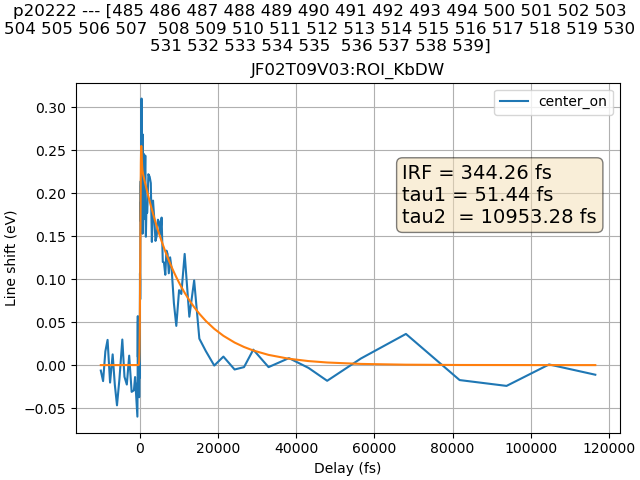

In [35]:
if 'Ka' in ROI:
    curve2fit = np.copy(width_on)
    start_x = 1
    label = 'width_on'
    ylabel = 'Linewidth (eV)'
else:
    curve2fit = np.copy(center_on)
    start_x = y_axis_rebin[center]
    label = 'center_on'
    ylabel = 'Line shift (eV)'

###################### 1 exp #################################
# p0 = [0, 100, 1, 1000,  start_x]
# popt,_  = curve_fit(model_decay_1exp, all_Delay_fs_TT_noNans, curve2fit, p0=p0, maxfev=40000)
# y_fit = model_decay_1exp(all_Delay_fs_TT_noNans, *popt)

###################### 2 exp #################################
p0 = [0, 100, -1, 1000, start_x, -1, 10000]
popt,_  = curve_fit(model_decay_2exp, all_Delay_fs_TT_noNans, curve2fit, p0=p0, maxfev=40000)
y_fit = model_decay_2exp(all_Delay_fs_TT_noNans, *popt)

fig, ax = plt.subplots(constrained_layout=True)
plt.suptitle("\n".join(wrap(titlestring_stack)))
plt.title(ROI)

plt.plot(all_Delay_fs_TT_noNans, curve2fit-np.average(curve2fit[0:5]), label = label)
plt.plot(all_Delay_fs_TT_noNans, y_fit-np.average(y_fit[0:5]))#, label = 'center ON')

popt = np.pad(popt, (0, 7-len(popt)), 'constant', constant_values=np.nan)
boxstyle = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
boxtext = '\n'.join((r'IRF = {:.2f} fs'.format(np.abs(popt[1]*2.3548)),
                     r'tau1 = {:.2f} fs'.format(np.abs(popt[3])),
                     r'tau2  = {:.2f} fs'.format(np.abs(popt[6]))))
plt.text(0.6, 0.6, boxtext, transform=ax.transAxes, bbox=boxstyle, fontsize=14)

#plt.xlim(-10000, 0)
plt.xlabel ('Delay (fs)')
plt.ylabel(ylabel)
plt.legend (loc = 'best')
plt.grid()
plt.show()

#plt.savefig(savedir +'/{}_delay_range_GS.png'.format(ROI.split(':')[-1]))

In [468]:
H2O_all_KbUP = np.copy(curve2fit)
H2O_all_KbUP_times = np.copy(all_Delay_fs_TT_noNans)

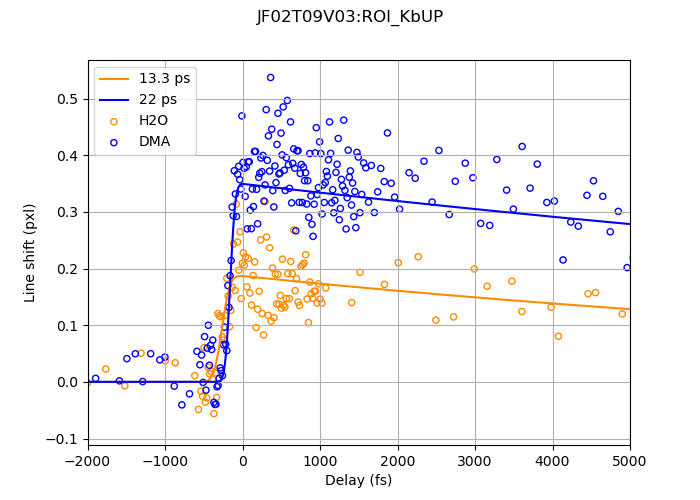

In [474]:
ROI = 'JF02T09V03:ROI_KbUP'
savedir = '../Claudio/PNG/'

p0 = [0, 100, -1, 1000,  8450]
popt_H2O,_  = curve_fit(model_decay_1exp, H2O_all_KbUP_times, H2O_all_KbUP, p0=p0, maxfev=40000)
y_fit_H2O = model_decay_1exp(H2O_all_KbUP_times, *popt_H2O)
popt_DMA,_  = curve_fit(model_decay_1exp, DMA_all_KbUP_times, DMA_all_KbUP, p0=p0, maxfev=40000)
y_fit_DMA = model_decay_1exp(DMA_all_KbUP_times, *popt_DMA)


fig = plt.figure(figsize = (7,5))
fig.suptitle(ROI)
ax1 = fig.add_subplot(111)
#ax2 = plt.twinx(ax1)

ax1.scatter(H2O_all_KbUP_times, H2O_all_KbUP-np.average(H2O_all_KbUP[0:5]), label = 'H2O', s=20, edgecolor = 'darkorange', facecolors='none')
#ax1.plot(H20_all_KbUP_times, H20_all_KbUP, label = 'H2O', color = 'darkorange')
ax1.plot(H2O_all_KbUP_times, y_fit_H2O-np.average(y_fit_H2O[0:5]), color = 'darkorange', label = '13.3 ps')
ax1.scatter(DMA_all_KbUP_times, DMA_all_KbUP-np.average(DMA_all_KbUP[0:5]), label = 'DMA', s=20, edgecolor = 'blue', facecolors='none')
#ax2.plot(DMA_all_KbUP_times, DMA_all_KbUP, label = 'DMA', color='blue')
ax1.plot(DMA_all_KbUP_times, y_fit_DMA-np.average(y_fit_DMA[0:5]), color='blue', label = '22 ps')

lines, labels = ax1.get_legend_handles_labels()
#lines2, labels2 = ax2.get_legend_handles_labels()
#ax1.legend(lines + lines2, labels + labels2, loc='best')
plt.legend(loc='best')

ax1.set_xlabel('Delay (fs)')
ax1.set_ylabel('Line shift (pxl)')

ax1.set_xlim(-2000, 5000)

ax1.grid()
plt.show()

plt.savefig(savedir +'/{}_water_DMA_comp_short.png'.format(ROI.split(':')[-1]))

<a id='model_fit'></a>
## Fit with model curves 

### Load model curves

In [36]:
filename_Singlet = '../Claudio/Kbeta_Fe(II)bmip2.txt'
filename_Doublet = '../Claudio/Kbeta_Fe(III)CN6.txt'
filename_Triplet = '../Claudio/Kbeta_Fe(II)Pc.txt'
#filename_Quartet = '../Claudio/Kbeta_Fe(II)PcCl.txt'
filename_Quintet = '../Claudio/Kbeta_Fe(II)acac2.txt'
filename_CN6     = '../Claudio/Kbeta_Fe(II)CN6.txt'
filename_bpy     = '../Claudio/Kbeta_Fe(II)bpy3.txt'
filename_CN4bpy  = '../Claudio/Kbeta_Fe(II)CN4bpy.txt'

with open(filename_Singlet) as f:
    data = np.loadtxt(f)
singlet_ref = data[:,1]
singlet_eV  = data[:,0]

with open(filename_Doublet) as f:
    data = np.loadtxt(f)
doublet_ref = data[:,1]

with open(filename_Triplet) as f:
    data = np.loadtxt(f)
triplet_ref = data[:,1]
triplet_eV  = data[:,0]

with open(filename_Quintet) as f:
    data = np.loadtxt(f)
quintet_ref = data[:,1]
quintet_eV  = data[:,0]

##################################################

with open(filename_CN6) as f:
    data = np.loadtxt(f)
CN6_ref = data[:,1]

with open(filename_bpy) as f:
    data = np.loadtxt(f)
bpy_ref = data[:,1]

with open(filename_CN4bpy) as f:
    data = np.loadtxt(f)
CN4bpy_ref = data[:,1]


##################################################

# plt.figure()
# plt.plot(singlet_eV, CN6_ref, label = 'GS CN6')
# plt.plot(singlet_eV, bpy_ref, label = 'GS bpy')

# plt.plot(singlet_eV, GS_ref, label = 'GS')
# plt.plot(singlet_eV, doublet_ref, label = 'doublet')
# plt.plot(triplet_eV, triplet_ref, label = 'triplet')
# plt.legend(loc='best')
# plt.grid()
# plt.show()

In [37]:
delta_y_axis = y_axis_rebin[-1]-y_axis_rebin[1]
common_energy = np.copy(y_axis_rebin[1:])

GS_CN6_interp       = np.interp(common_energy, singlet_eV, CN6_ref, period=delta_y_axis)
GS_bpy_interp       = np.interp(common_energy, singlet_eV, bpy_ref, period=delta_y_axis)
CN4bpy_interp       = np.interp(common_energy, singlet_eV, CN4bpy_ref, period=delta_y_axis)
doublet_ref_interp  = np.interp(common_energy, singlet_eV, doublet_ref, period=delta_y_axis)
triplet_ref_interp  = np.interp(common_energy, triplet_eV, triplet_ref, period=delta_y_axis)
quintet_ref_interp  = np.interp(common_energy, quintet_eV, quintet_ref, period=delta_y_axis)


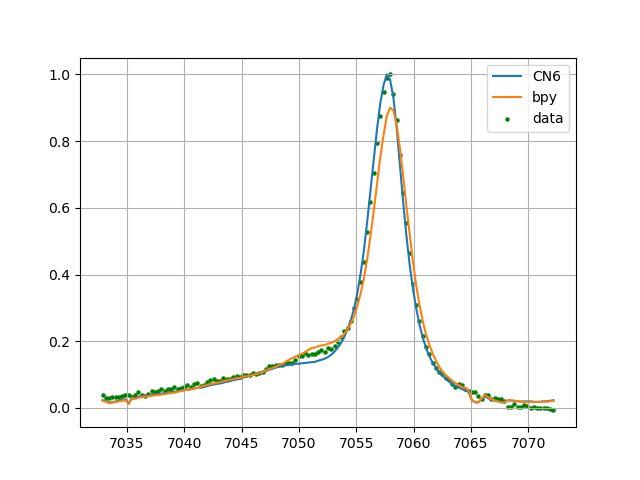

[[Model]]
    Model(fit_Kb_gs)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 13
    # data points      = 139
    # variables        = 2
    chi-square         = 0.01747930
    reduced chi-square = 1.2759e-04
    Akaike info crit   = -1244.38842
    Bayesian info crit = -1238.51947
[[Variables]]
    g1:  0.63318023 +/- 0.02204268 (3.48%) (init = 0.5)
    g2:  0.29024915 +/- 0.02328781 (8.02%) (init = 0.5)
[[Correlations]] (unreported correlations are < 0.100)
    C(g1, g2) = -0.990


In [38]:
found_delay_neg = popt[0] - popt[1]*2.3548
index_delay_neg = np.int(np.argwhere(all_Delay_fs_TT_noNans > found_delay_neg)[0])
#spectra_GS   = np.average(off_2D[:,:index_delay_neg], axis=1)
spectra_GS   = np.average(off_2D[:,:], axis=1)

def fit_Kb_gs(x, g1,g2):
    total = g1*GS_CN6_interp + g2*GS_bpy_interp
    #total = 0.66*GS_CN6_interp + 0.33*GS_bpy_interp
    return total

from lmfit import Model, Parameters
mymodel = Model(fit_Kb_gs)
params = Parameters()
params.add('g1', value=0.5, min=0)
params.add('g2', value=0.5, min=0)

data2fit = (spectra_GS[1:]-np.average(spectra_GS[1:10]))/np.max(spectra_GS[1:]-np.average(spectra_GS[1:10]))

result = mymodel.fit(data2fit, params,  x=common_energy)
g1 = result.best_values['g1']
g2 = result.best_values['g2']

plt.figure()
plt.plot(common_energy, GS_CN6_interp/max(GS_CN6_interp), label ='CN6')
plt.plot(common_energy, GS_bpy_interp/max(GS_CN6_interp), label ='bpy')
# plt.plot(common_energy, CN4bpy_interp/max(CN4bpy_interp), label ='Singlet')
# plt.plot(common_energy, doublet_ref_interp/max(CN4bpy_interp), label ='Doublet')
# plt.plot(common_energy, triplet_ref_interp/max(CN4bpy_interp), label ='Triplet')
# plt.plot(common_energy, quintet_ref_interp/max(CN4bpy_interp), label ='Quintet')


plt.scatter(common_energy, data2fit, label ='data', color = 'green', s=5)
# plt.axvline(x=7057.75, ls='--')
# plt.axvline(x=7059, color = 'green', ls='--')


plt.legend(loc='best')
plt.grid()
plt.show()

print(result.fit_report())
#plt.savefig(savedir +'/models_before_fit.png'.format(ROI.split(':')[-1]))

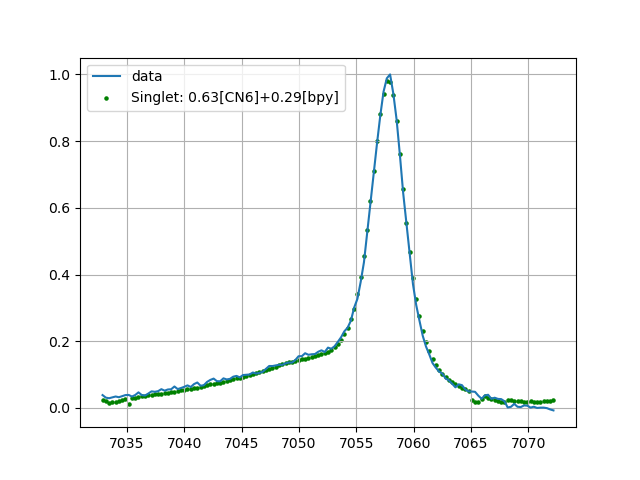

In [39]:
#GS_ref = 2/3*(CN6_ref) + 1/3*(bpy_ref)
GS_ref = g1*(GS_CN6_interp) + g2*(GS_bpy_interp)
plt.figure()
# plt.plot(common_energy, GS_CN6_interp, label='CN6')#/np.max(CN6_ref))
# plt.plot(common_energy, GS_bpy_interp, label='bpy')#/np.max(bpy_ref))
plt.plot(common_energy, data2fit, label='data')#/np.max(bpy_ref))
plt.scatter(common_energy, GS_ref, color='green', s=5, label='Singlet: {:.2f}[CN6]+{:.2f}[bpy]'.format(g1,g2))#/np.max(GS_ref))

plt.legend(loc='best')
plt.grid()

plt.show()
#plt.savefig(savedir + '/{}_linear_GS.png'.format(ROI.split(':')[-1]))

-106.79062254374122


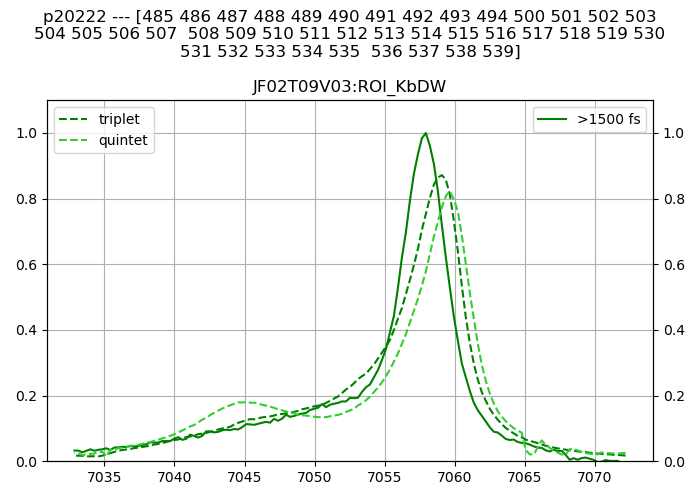

In [40]:
chosen_delay_inf = 300
chosen_delay_sup = 1500
chosen_delay_rec = 15000

######################################################33

found_delay_neg = popt[0] - popt[1]*2.3548
print (found_delay_neg)

index_delay_inf = np.int(np.argwhere(all_Delay_fs_TT_noNans > chosen_delay_inf)[0])
index_delay_sup = np.int(np.argwhere(all_Delay_fs_TT_noNans > chosen_delay_sup)[0])
index_delay_neg = np.int(np.argwhere(all_Delay_fs_TT_noNans > found_delay_neg)[0])
#index_delay_rec = np.int(np.argwhere(all_Delay_fs_TT_noNans > chosen_delay_rec)[0])


spectra_MLCT = np.average(on_2D[:,index_delay_inf:index_delay_sup], axis=1)
spectra_MC   = np.average(on_2D[:,index_delay_sup:], axis=1)
spectra_GS   = np.average(on_2D[:,:index_delay_neg], axis=1)
#spectra_GS_r = np.average(on_2D[:,index_delay_rec:], axis=1)

doublet_LC = 0.5*GS_ref + 0.5*doublet_ref_interp
triplet_LC = 0.8*GS_ref + 0.2*doublet_ref_interp + 0*triplet_ref_interp

fig = plt.figure(figsize = (7,5))
fig.suptitle("\n".join(wrap(titlestring_stack)))
ax1 = fig.add_subplot(111)
ax2 = plt.twinx(ax1)
ax1.set_title(ROI)

#ax1.plot(common_energy, (spectra_GS[1:]-np.average(spectra_GS[1:10]))/np.max(spectra_GS[1:]-np.average(spectra_GS[1:10])), label = '<{:.0f} fs'.format(found_delay_neg), color = 'blue')
#ax1.plot(common_energy, spectra_GS_r, label = '>{:.0f} fs'.format(chosen_delay_rec))
#ax1.plot(common_energy, (spectra_MLCT[1:]-np.average(spectra_MLCT[1:10]))/np.max(spectra_MLCT[1:]-np.average(spectra_MLCT[1:10])), label = '{}-{} fs'.format(chosen_delay_inf, chosen_delay_sup), color = 'darkorange')
ax1.plot(common_energy, (spectra_MC[1:]-np.average(spectra_MC[1:10]))/np.max(spectra_MC[1:]-np.average(spectra_MC[1:10])), label = '>{} fs'.format(chosen_delay_sup), color = 'green')

#ax2.plot(common_energy, singlet_ref, '--', label ='singlet', color = 'blue')
# ax2.plot(common_energy, GS_ref/np.max(GS_ref), '--', label ='singlet', color = 'blue')
#ax2.plot(common_energy, doublet_ref_interp/np.max(GS_ref), '--', label ='doublet', color = 'darkorange')
#ax2.plot(common_energy, doublet_LC/np.max(doublet_LC), '--', label ='doublet', color = 'darkorange')
ax2.plot(common_energy, triplet_ref_interp/np.max(GS_ref), '--', label ='triplet', color = 'green')
#ax2.plot(common_energy, triplet_LC/np.max(triplet_LC), '--', label ='triplet', color = 'green')
ax2.plot(common_energy, quintet_ref_interp/np.max(GS_ref), '--', label ='quintet', color = 'limegreen')

ax1.set_ylim(0, 1.1)
ax2.set_ylim(0, 1.1)
#ax1.set_xlim(7052, 7065)

ax1.legend(loc='best')
ax2.legend(loc='upper left')
ax1.grid()
plt.tight_layout()
plt.show()

#plt.savefig(savedir + '/{}_triplet.png'.format(ROI.split(':')[-1]))

In [41]:
GS_ref_norm             = GS_ref/np.max(GS_ref)
doublet_ref_interp_norm = doublet_ref_interp/np.max(GS_ref)
triplet_ref_interp_norm = triplet_ref_interp/np.max(GS_ref)
quintet_ref_interp_norm = quintet_ref_interp/np.max(GS_ref)

def fit_Kb_multi(x, c1,c2,c3,c4):
    #total = c1*GS_ref_interp + c2*doublet_ref_interp + c3*triplet_ref_interp
    #total = c1*GS_ref_norm + c2*doublet_ref_interp_norm + c3*triplet_ref_interp_norm + c4*quintet_ref_interp_norm
    #total = c1*GS_ref_norm +                              c3*triplet_ref_interp_norm + c4*quintet_ref_interp_norm
    total = c1*GS_ref_norm + c2*doublet_ref_interp_norm + c3*triplet_ref_interp_norm + c4*quintet_ref_interp_norm
    return total

from lmfit import Model, Parameters
mymodel = Model(fit_Kb_multi)

params = Parameters()
params.add('c1', value=0.25,  min=0)
params.add('c2', value=0.25,  min=0)
params.add('c3', value=0.25,  min=0)
params.add('c4', value=0.25,  min=0)
#params.add('c1', expr='1-c2-c3')
# params.add('c2', expr='1-c1-c3')
# params.add('c3', expr='1-c1-c2')

#params = mymodel.make_params(c1=0.4, c2=0.1, c3=0.5)

# params['c1'].max = 1
# params['c1'].min = 0
# params['c2'].max = 1
# params['c2'].min = 0
# params['c3'].max = 1
# params['c3'].min = 0

#data2fit = (spectra_GS[1:]-np.average(spectra_GS[1:10]))/np.max(spectra_GS[1:]-np.average(spectra_GS[1:10]))
data2fit = (spectra_MLCT[1:]-np.average(spectra_MLCT[1:10]))/np.max(spectra_MLCT[1:]-np.average(spectra_MLCT[1:10]))
#data2fit = (spectra_MC[1:]-np.average(spectra_MC[1:10]))/np.max(spectra_MC[1:]-np.average(spectra_MC[1:10]))

#data2fit = (spectra_GS[1:]-np.average(spectra_GS[1:10]))
#data2fit = (spectra_MLCT[1:]-np.average(spectra_MLCT[1:10]))
#data2fit = (spectra_MC[1:]-np.average(spectra_MC[1:10]))

#result = mymodel.fit(data2fit/np.max(data2fit), params,  x=common_energy)
result = mymodel.fit(data2fit, params,  x=common_energy)
print(result.fit_report())

[[Model]]
    Model(fit_Kb_multi)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 39
    # data points      = 139
    # variables        = 4
    chi-square         = 0.01899445
    reduced chi-square = 1.4070e-04
    Akaike info crit   = -1228.83345
    Bayesian info crit = -1217.09556
[[Variables]]
    c1:  0.53588511 +/- 0.03666318 (6.84%) (init = 0.25)
    c2:  0.46956716 +/- 0.07161002 (15.25%) (init = 0.25)
    c3:  7.7781e-07 +/- 0.04123070 (5300899.54%) (init = 0.25)
    c4:  0.03752931 +/- 0.02510274 (66.89%) (init = 0.25)
[[Correlations]] (unreported correlations are < 0.100)
    C(c1, c2) = -0.919
    C(c2, c3) = -0.842
    C(c3, c4) = -0.798
    C(c1, c3) =  0.591
    C(c2, c4) =  0.395
    C(c1, c4) = -0.125


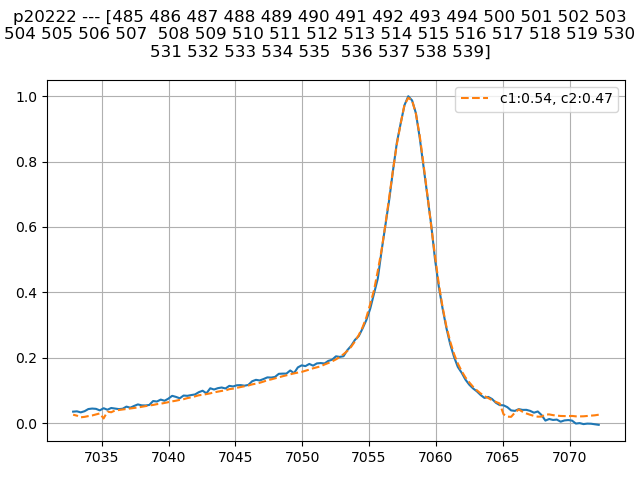

In [42]:
plt.figure()
plt.suptitle("\n".join(wrap(titlestring_stack)))
plt.plot(common_energy, data2fit)
plt.plot(common_energy, result.best_fit, '--', label='c1:{:.2f}, c2:{:.2f}'.format(result.params.get('c1').value, result.params.get('c2').value))
plt.legend(loc='best')
plt.grid()
plt.tight_layout()
plt.show()


In [43]:
c1 = []
c2 = []
c3 = []
c4 = []
model_2D_full = []
data_2D_full = []

for delay_index in range(len(all_Delay_fs_TT_noNans)):
    spectrum = on_2D[:,delay_index]
    spec2fit = spectrum[1:]-np.average(spectrum[1:10])
    mod = Model(fit_Kb_multi)
    
    params = Parameters()
    params.add('c1', value=0.33, min=0)
    params.add('c2', value=0.33, min=0)
    params.add('c3', value=0.33, min=0)
    params.add('c4', value=0.33, min=0)
#    params['c2'].set(0, vary=False)
    
#    params = mod.make_params(c1=1, c2=0, c3=0)

    out = mod.fit(spec2fit/np.max(spec2fit), params,  x=common_energy)
    c1.append(out.params.get('c1').value)
    c2.append(out.params.get('c2').value)
    c3.append(out.params.get('c3').value)
    c4.append(out.params.get('c4').value)
    
    data_2D_full.append(spec2fit)
    model_2D_full.append(out.params.get('c1').value*GS_ref_norm + 
                         out.params.get('c2').value*doublet_ref_interp_norm +
                         out.params.get('c3').value*triplet_ref_interp_norm + 
                         out.params.get('c4').value*quintet_ref_interp_norm)
model_2D_full = np.asarray(model_2D_full).T
data_2D_full  = np.asarray(data_2D_full).T

NameError: name 'data_2D_noDoublet' is not defined

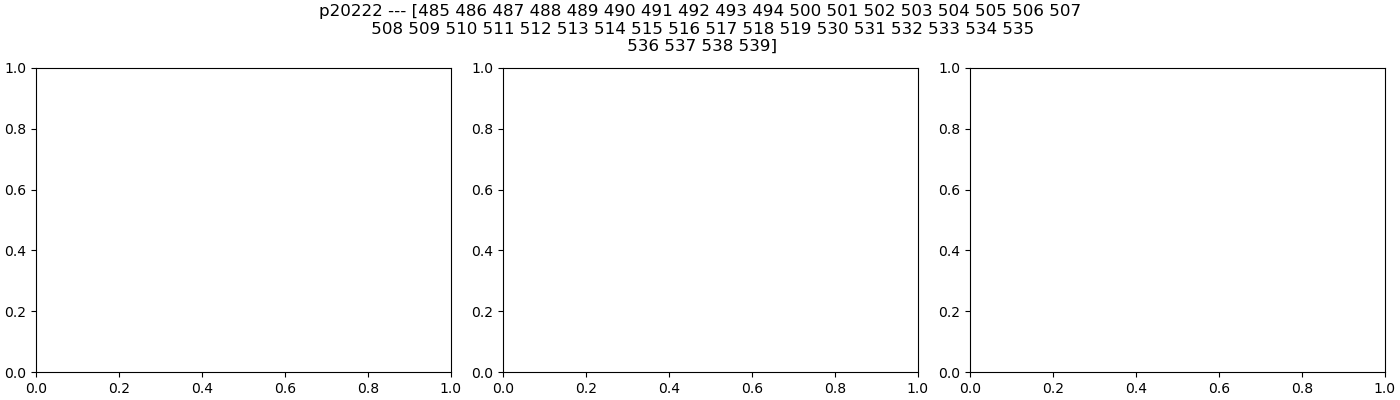

In [44]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(14, 4), constrained_layout=True)

plt.suptitle(titlestring_stack)

pcm1 = ax1.pcolormesh(all_Delay_fs_TT_noNans, y_axis_rebin, data_2D_noDoublet, cmap='jet', vmin = 0, vmax = 1)
pcm2 = ax2.pcolormesh(all_Delay_fs_TT_noNans, y_axis_rebin[1:], model_2D_noDoublet, cmap='jet', vmin = 0, vmax = 1)
pcm3 = ax3.pcolormesh(all_Delay_fs_TT_noNans, y_axis_rebin[1:], data_2D_noDoublet - model_2D_noDoublet,cmap='bwr', vmin = -0.2, vmax = 0.2)

fig.colorbar(pcm1, ax=ax1)
fig.colorbar(pcm2, ax=ax2)
fig.colorbar(pcm3, ax=ax3)

ax1.set_title('Experiment')
ax2.set_title('Model')
ax3.set_title('Residuals')

for ax in (ax1,ax2,ax3):
    ax.set_ylim(7054, 7062)
    ax.set_ylabel('Emission energy (eV)')
    ax.set_xlabel('{} ({})'.format(scan.parameters['name'][0], scan.parameters['units'][0]))

plt.show()
#plt.savefig(savedir + '/{}_2D_model_Full.png'.format(ROI.split(':')[-1]))

In [109]:
np.shape(data_2D)

(139, 149)

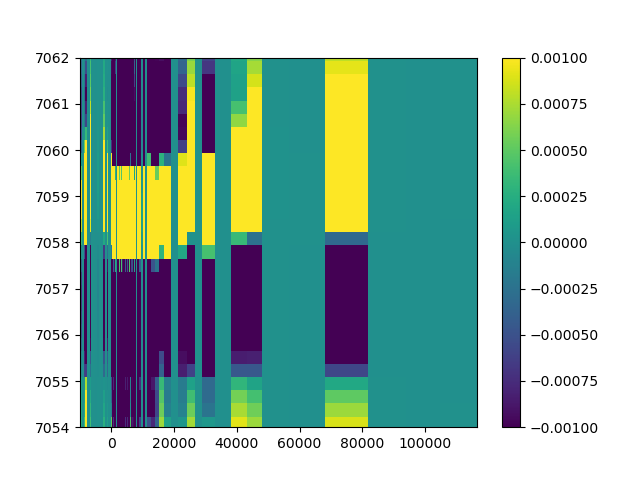

In [134]:
plt.figure()
plt.pcolormesh(all_Delay_fs_TT_noNans, y_axis_rebin[1:], model_2D_full - model_2D_noDoublet, vmin = -0.001, vmax = 0.001)
plt.colorbar()
plt.ylim(7054, 7062)
plt.show()

[ 1.56611945e+02  9.16959242e+01  6.30620426e+00  5.76836622e+03
  9.73274004e-01 -6.52594657e+00  5.90593888e+03]
[ 1.62498196e+02  8.67471535e+01 -9.68908808e+00  6.78937794e+03
  3.66708758e-03  9.97106491e+00  6.89103996e+03]
[ 5.83335925e+02  3.44026278e+01 -5.75029536e-03  1.49081324e+01
  1.69866232e-03  1.66494918e-02  6.05616725e+03]


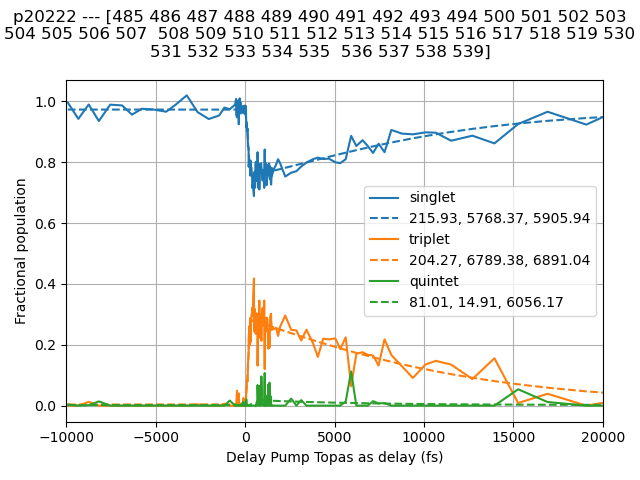

In [82]:
y = np.stack([c1, c3, c4])
lab = ['singlet','triplet','quintet']

plt.figure()
plt.suptitle("\n".join(wrap(titlestring_stack)))
p0 = [0,  200,   1,    1000, 1, 1,    10000]
for index,y_i in enumerate(y):
    plt.plot(all_Delay_fs_TT_noNans, y_i, label=lab[index])
    popt,_  = curve_fit(model_decay_2exp, all_Delay_fs_TT_noNans, y_i, p0=p0, maxfev=40000)
    print (popt)
    y_fit = model_decay_2exp(all_Delay_fs_TT_noNans, *popt)
    plt.plot(all_Delay_fs_TT_noNans, y_fit, ls='--', color=plt.gca().lines[-1].get_color(), label = '{:.2f}, {:.2f}, {:.2f}'.format(popt[1]*2.3548, popt[3], popt[6]))
    
plt.legend(loc='best')
plt.grid()
plt.ylabel('Fractional population')
plt.xlim(-10000, 20000)
plt.xlabel('{} ({})'.format(scan.parameters['name'][0], scan.parameters['units'][0]))
plt.tight_layout()

plt.show()
plt.savefig(savedir + '/{}_fractional_fit_noDoublet_FIT.png'.format(ROI.split(':')[-1]))

In [426]:
1.62495047e+02  8.67476475e+01 -9.07586961e+00  6.78650820e+03 3.66459522e-03  9.35784974e+00  6.89493264e+03
x0,             sigma,         amp1,            tau1,          C,              amp2, tau2

array([ 5.84242463e+02,  3.39164928e+01, -6.08561314e-03,  1.49063757e+01,
        1.69566794e-03,  1.66510065e-02,  6.05939302e+03])

In [422]:
def model_decay_2exp_combined(x, x0, sigma, tau1, tau2,  C, amp11, amp12, amp21, amp22, amp31, amp32):
    first  = model_decay_2exp(x, x0, sigma, amp11, tau1, C, amp21, tau2)
    second = model_decay_2exp(x, x0, sigma, amp21, tau1, C, amp22, tau2)
    third  = model_decay_2exp(x, x0, sigma, amp31, tau1, C, amp32, tau2)
    return np.concatenate((first, second, third))

In [428]:
     #x0, sigma, tau1, tau2, C1, amp11, amp12, amp21, amp22, amp31, amp32
p0 = [150,  90,   2000, 1000, 1,  4,     -5,     -9,     9,     1,     1]
(x0, sigma, tau1, tau2,  C, *amp),_ = curve_fit(model_decay_2exp_combined, all_Delay_fs_TT_noNans, y.ravel(), p0=p0, maxfev=40000)

In [431]:
sigma

317736.6647406246

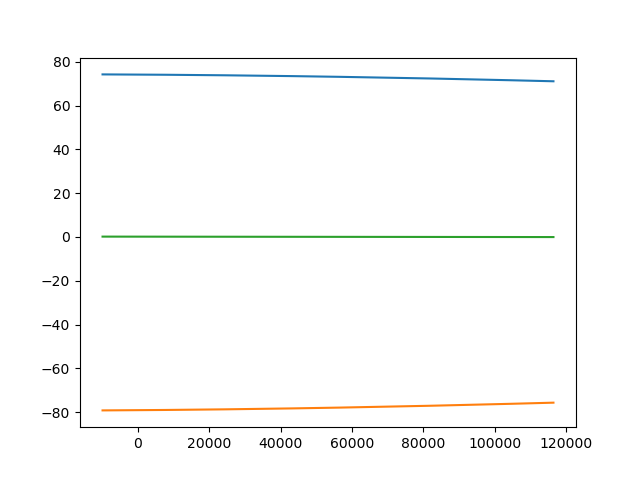

In [429]:
plt.figure()
for amp_i,y_i in enumerate(y):
    y_fit = model_decay_2exp(all_Delay_fs_TT_noNans, x0, sigma, amp[amp_i], tau1, C, amp[amp_i+1], tau2)
    plt.plot(all_Delay_fs_TT_noNans, y_fit)
plt.show()

In [365]:
print (popt_c1[1], popt_c1[3], popt_c1[6]) 
print (popt_c3[1], popt_c3[3], popt_c3[6]) 
len(all_Delay_fs_TT_noNans)
len(y.ravel())

94.81569708918416 6655.620476861684 6889.445014759275
289.4516793082989 68.95978418782533 13216.967460847698


447

In [379]:
p0 = [0,  50,   1,    1000, 1, 1,    10000]
y = np.stack([c2, c3])
#popt,_ = curve_fit(lambda all_Delay_fs_TT_noNans, x0, sigma, amp1, tau1, C, amp2, tau2: np.tile(model_decay_2exp(all_Delay_fs_TT_noNans, x0, sigma, amp1, tau1, C, amp2, tau2), len(y)), all_Delay_fs_TT_noNans, y.ravel())
popt,_ = curve_fit(lambda all_Delay_fs_TT_noNans, x0, sigma, amp1, tau1, C, amp2, tau2: np.tile(model_decay_2exp(all_Delay_fs_TT_noNans, x0, sigma, amp1, tau1, C, amp2, tau2), len(y)), all_Delay_fs_TT_noNans, y.ravel(), p0=p0, maxfev=40000)

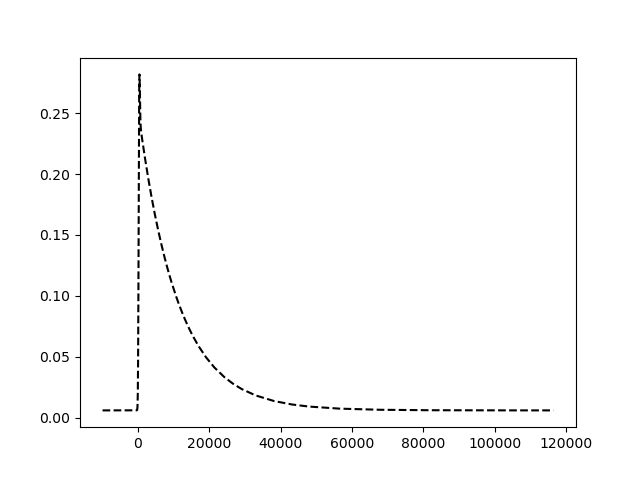

360.4106924896408 49.39374231592184 10979.266583276678


In [382]:
plt.figure()
# plt.plot(all_Delay_fs_TT_noNans, c1, label='singlet')
# plt.plot(all_Delay_fs_TT_noNans, c2, label='doublet')
# plt.plot(all_Delay_fs_TT_noNans, c3, label='triplet')

plt.plot(all_Delay_fs_TT_noNans, model_decay_2exp(all_Delay_fs_TT_noNans, *popt), linestyle="--", color="black")
plt.show()
print (popt[1]*2.3548, popt[3], popt[6])

In [350]:
np.shape(y)

(3, 5)

In [ ]:
p0[0], p0[1], p0[2], p0[3], p0[4], p0[5]

x = [0 1 2 3 4]
y = [[-0.00493277  1.06534288  2.20158068  2.97271146  3.9605862 ]
 [-0.15968773  0.9864585   2.14538563  2.9679479   4.07006855]
 [-0.08468904  1.29381835  1.6831207   2.87661621  3.84309761]]


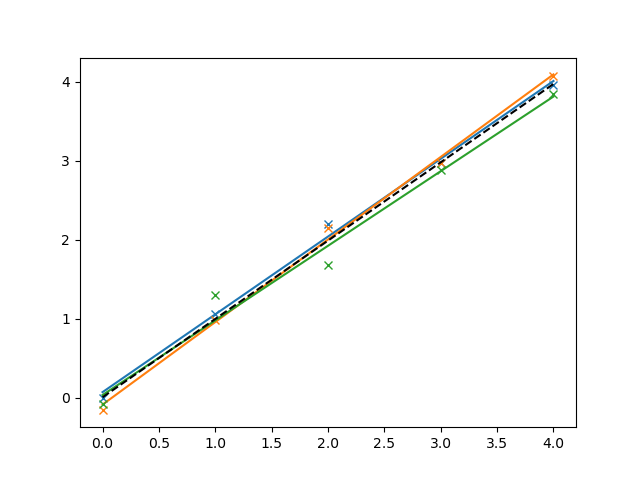

In [366]:
m = 5
n = 3
x = np.arange(m)
y = np.array([x + np.random.normal(0, 0.2, len(x)) for _ in range(n)])
print("x =", x)
print("y =", y)

def f(x, a, b):
    return a * x + b
plt.figure()
# single fits to each dataset
for y_i in y:
    popt, pcov = curve_fit(f, x, y_i)
    plt.plot(x, y_i, linestyle="", marker="x")
    plt.plot(x, f(x, *popt), color=plt.gca().lines[-1].get_color())

# global fit to concatenated dataset
popt, pcov = curve_fit(lambda x, a, b: np.tile(f(x, a, b), len(y)), x, y.ravel())
plt.plot(x, f(x, *popt), linestyle="--", color="black")

plt.show()

In [368]:
len(y.ravel())

15

<a id='energy_calib'></a>
## Energy calibration 

### Load ref spectra

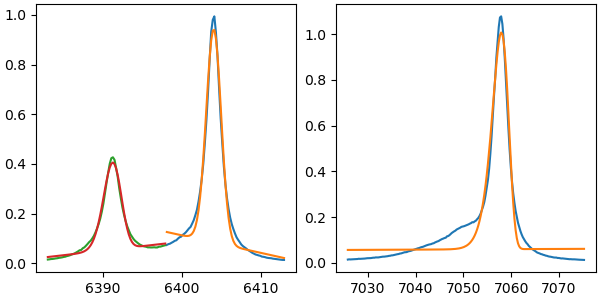

[6404.001706405278, 6391.16566403165]
[7057.708266035336, 7055.607686689056, 7059.808845381616]


In [322]:
filename_Ka = '../Claudio/Kalpha_Fe(II)CN4bpy.txt'
filename_Kb = '../Claudio/Kbeta_Fe(II)CN4bpy.txt'

######################################################

with open(filename_Ka) as f:
    data = np.loadtxt(f)
Ka_ref = data[:,1]
Ka_eV  = data[:,0]

with open(filename_Kb) as f:
    data = np.loadtxt(f)
Kb_ref = data[:,1]
Kb_eV  = data[:,0]

Ka_ref1, Ka_ref2 = np.split(Ka_ref[1:],2)
Ka_eV1, Ka_eV2 = np.split(Ka_eV[1:],2)

p0_ref2 = [Ka_eV2[np.argmax(Ka_ref2)], 5, 10, 0.1, -1, 0.0001, 0.1]
p0_ref1 = [Ka_eV1[np.argmax(Ka_ref1)], 5, 10, 0.1, -1, 0.0001, 0.1]

popt_ref_Ka2,_ = curve_fit(AsymPseudoVoigt, Ka_eV2, Ka_ref2, p0=p0_ref2, maxfev=40000)
popt_ref_Ka1,_ = curve_fit(AsymPseudoVoigt, Ka_eV1, Ka_ref1, p0=p0_ref1, maxfev=40000)

p0_ref3 = [Kb_eV[np.argmax(Kb_ref)], 5, 10, 0.1, -1, 0.0001, 0.1]

popt_ref_Kb,_ = curve_fit(AsymPseudoVoigt, Kb_eV, Kb_ref, p0=p0_ref3, maxfev=40000)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(6, 3), constrained_layout=True)
ax1.plot(Ka_eV1, Ka_ref1)
ax1.plot(Ka_eV1, AsymPseudoVoigt(Ka_eV1, *popt_ref_Ka1))
ax1.plot(Ka_eV2, Ka_ref2)
ax1.plot(Ka_eV2, AsymPseudoVoigt(Ka_eV2, *popt_ref_Ka2))

ax2.plot(Kb_eV, Kb_ref)
ax2.plot(Kb_eV, AsymPseudoVoigt(Kb_eV, *popt_ref_Kb))
plt.show()

center_Ka1 = popt_ref_Ka1[0]
center_Ka2 = popt_ref_Ka2[0]
ref_Ka_points = [center_Ka1, center_Ka2]

center_Kb = popt_ref_Kb[0]
width_Kb = popt_ref_Kb[2]
ref_Kb_points = [center_Kb, center_Kb-width_Kb/2, center_Kb+width_Kb/2]

print (ref_Ka_points)
print (ref_Kb_points)

### Load data (darks)

In [57]:
pgroup = 'p20222'
Loaddir = '../Claudio/Reduced_XES_timescans_TT_rot/_stacks/run0308-FebpyCN4_H20_4uJ_mixGain_stack_20_runs/'
run2load = Loaddir.split('/')[-2]

titlestring_stack = run2load
savedir = '../Claudio/PNG/'+run2load #+'_rot'
run_array = np.load(Loaddir + 'run_array.npy', allow_pickle=True).item()
for key in run_array.keys():
    s_all_off = run_array[key]["all_spectra_shots_off"]
    ROIs      = run_array[key]["ROIs"]
    meta = run_array[key]["meta"]
    if len(run_array[key]["runlist"]) != 0:        
        runlist = run_array[key]["runlist"]
        titlestring_stack = pgroup + ' --- ' +str(runlist)

In [58]:
calibration = {}
for ROI in ROIs:
    if "bkg" in ROI:
        continue
    GS = np.average(s_all_off[ROI], axis=0)
    pxl_axis = np.arange(np.array(meta[ROI+'-roi']).flatten()[-2], np.array(meta[ROI+'-roi']).flatten()[-1], 1)
    ROI_size = np.array(meta[ROI+'-roi'])[1][1]-np.array(meta[ROI+'-roi'])[1][0]
    
    if "Kb" in ROI:
        p0_GS = [pxl_axis[np.argmax(GS)], 5, 10, 0.1, -1, 0.0001, 0.1]

        popt_GS,_ = curve_fit(AsymPseudoVoigt, pxl_axis, GS[:ROI_size], p0=p0_GS, maxfev=40000)
        center_GS = popt_GS[0]
        width_GS = popt_GS[2]

        GS_Kb_points = [center_GS, center_GS+width_GS/2, center_GS-width_GS/2]
        m, b = np.polyfit(GS_Kb_points, ref_Kb_points, 1) 
        calibration[ROI] = (m, b)
        #print (m, b)
        #energy_eV = m*yaxis + b
    if "Ka" in ROI:
        GS1, GS2 = np.split(GS[:ROI_size],2)
        pxl_axis1, pxl_axis2 = np.split(pxl_axis,2)

        p0_GS1 = [pxl_axis1[np.argmax(GS1)], 5, 10, 0.1, -1, 0.0001, 0.1]
        p0_GS2 = [pxl_axis2[np.argmax(GS2)], 5, 10, 0.1, -1, 0.0001, 0.1]

        popt_GS1,_ = curve_fit(AsymPseudoVoigt, pxl_axis1, GS1, p0=p0_GS1, maxfev=40000)
        popt_GS2,_ = curve_fit(AsymPseudoVoigt, pxl_axis2, GS2, p0=p0_GS2, maxfev=40000)
        center_GS1 = popt_GS1[0]
        center_GS2 = popt_GS2[0]
        
        GS_Ka_points = [center_GS1, center_GS2]
        m, b = np.polyfit(GS_Ka_points, ref_Ka_points, 1) 
        calibration[ROI] = (m, b)
        
with open(Loaddir + 'calibration.pkl', 'wb') as f:
    pickle.dump(calibration, f)   
calibration

{'JF02T09V03:ROI_KaDW': (-0.48114612323337863, 8859.624913397409),
 'JF02T09V03:ROI_KaUP': (-0.47851440310015153, 8844.82211555035),
 'JF02T09V03:ROI_KbDW': (-0.2916484144274616, 9523.489831961228),
 'JF02T09V03:ROI_KbUP': (-0.31850903370418865, 9750.866629580594)}

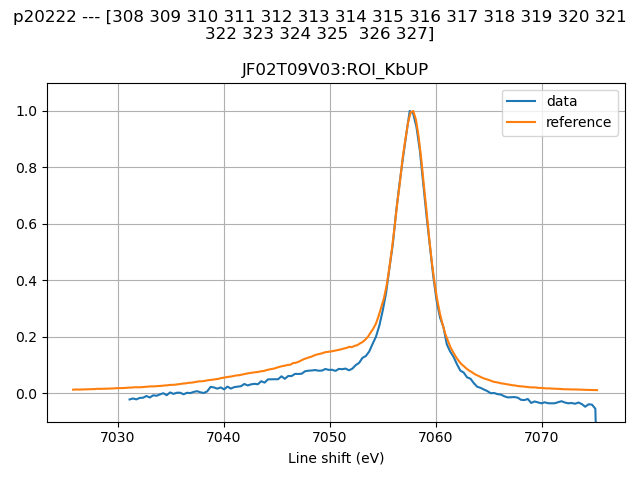

(-0.31850903370418865, 9750.866629580594)


In [79]:
ROI = 'JF02T09V03:ROI_KbUP'

#########################################
GS = np.average(s_all_off[ROI], axis=0)
pxl_axis = np.arange(np.array(meta[ROI+'-roi']).flatten()[-2], np.array(meta[ROI+'-roi']).flatten()[-1], 1)
ROI_size = np.array(meta[ROI+'-roi'])[1][1]-np.array(meta[ROI+'-roi'])[1][0]
(m,b) = calibration[ROI]

energy_eV = m*pxl_axis + b

if 'Ka' in ROI:
    ref_eV = Ka_eV
    ref_line = Ka_ref
if 'Kb' in ROI:
    ref_eV = Kb_eV
    ref_line = Kb_ref

GS2plot = (GS[:ROI_size]-np.average(GS[-20:-10]))/np.max(GS[:ROI_size]-np.average(GS[-20:-10]))
    
plt.figure()
plt.suptitle("\n".join(wrap(titlestring_stack)))
plt.title(ROI)
plt.plot(energy_eV, GS2plot, label='data')
plt.plot(ref_eV, (ref_line)/np.max(ref_line), label='reference')
plt.legend(loc='best')
plt.xlabel(ylabel)
plt.ylim(-0.1, 1.1)
plt.grid()
plt.tight_layout()
plt.show()
print (calibration[ROI])
#plt.savefig(savedir +'/{}_calibration.png'.format(ROI))

In [61]:
GS1 = np.copy(GS2plot)
energy1 = np.copy(energy_eV)

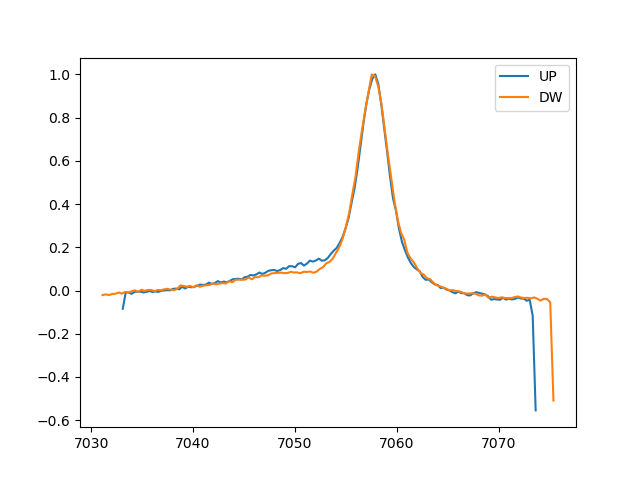

In [66]:
plt.figure()
plt.plot(energy1, GS1, label = 'UP')
plt.plot(energy_eV, GS2plot, label = 'DW')
plt.legend(loc='best')
plt.show()

In [41]:
ROI = 'JF02T09V03:ROI_KaDW'
GS = np.average(s_all_off[ROI], axis=0)
yaxis = np.arange(np.array(meta[ROI+'-roi']).flatten()[-2], np.array(meta[ROI+'-roi']).flatten()[-1], 1)
ROI_size = np.array(meta[ROI+'-roi'])[1][1]-np.array(meta[ROI+'-roi'])[1][0]

In [42]:
GS1, GS2 = np.split(GS[:ROI_size],2)
yaxis1, yaxis2 = np.split(yaxis,2)

p0_GS1  = [yaxis1[np.argmax(GS1)], 5, 10, 0.1, -1, 0.0001, 0.1]
p0_GS2 = [yaxis2[np.argmax(GS2)], 5, 10, 0.1, -1, 0.0001, 0.1]

popt_GS1,_ = curve_fit(AsymPseudoVoigt, yaxis1, GS1, p0=p0_GS1, maxfev=40000)
popt_GS2,_ = curve_fit(AsymPseudoVoigt, yaxis2, GS2, p0=p0_GS2, maxfev=40000)

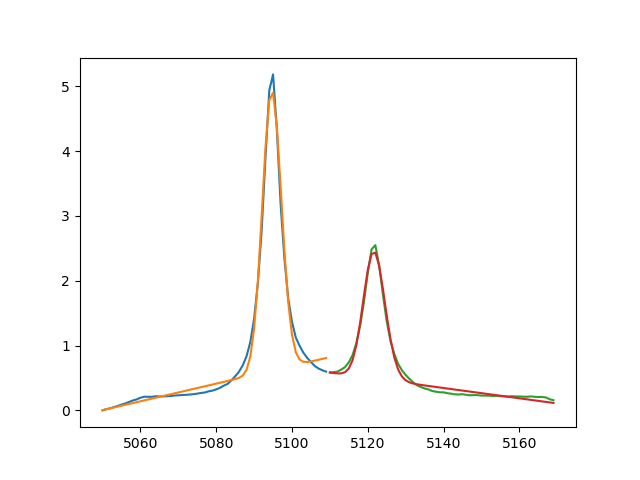

In [104]:
plt.figure()
plt.plot(pxl_axis1, GS1)
plt.plot(pxl_axis1, AsymPseudoVoigt(pxl_axis1, *popt_GS1))
plt.plot(pxl_axis2, GS2)
plt.plot(pxl_axis2, AsymPseudoVoigt(pxl_axis2, *popt_GS2))

plt.show()

In [44]:
print (popt_GS1[0], popt_GS2[0])
print (popt_ref_Ka1[0], popt_ref_Ka2[0])

5097.2348066205 5123.922445801303
6404.001706405278 6391.16566403165


In [45]:
m, b = np.polyfit((popt_GS1[0], popt_GS2[0]),(popt_ref1[0], popt_ref2[0]), 1) 
print (m, b)
energy_eV = m*yaxis + b

-0.4809733182717414 8855.63564535576


In [46]:
calibration[ROI] = (m, b)

In [47]:
calibration

{'JF02T09V03:ROI_KaUP': (-0.4754436770670698, 8826.232879852956),
 'JF02T09V03:ROI_KaDW': (-0.4809733182717414, 8855.63564535576)}

In [36]:
print (popt_ref1[0] - popt_ref2[0])
print (popt_GS1[0] - popt_GS2[0])
m = (popt_ref2[0] - popt_ref1[0])/(popt_GS2[0] - popt_GS1[0])
print (m)

12.836042373628516
-26.82142412552639
-0.47857422907727865


In [35]:
q = popt_ref2[0] - m*popt_GS2[0]
print (q)

8845.12759921108


In [146]:
3.751 - 3.8378

-0.08680000000000021

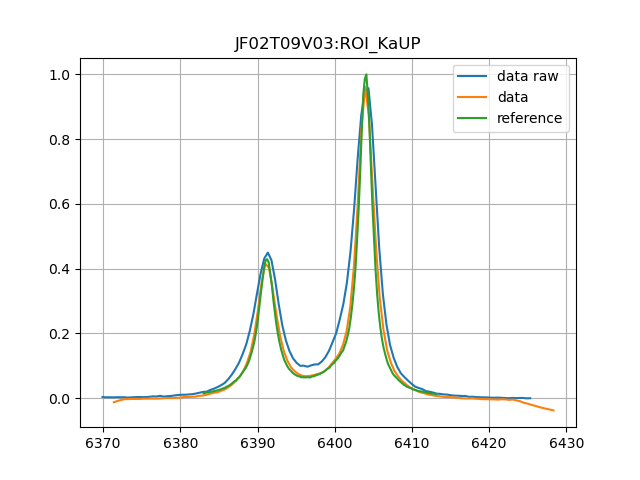

In [145]:
plt.figure()
plt.title(ROI)
plt.plot(energy_eV_raw, (GS_raw-np.average(GS_raw[0:10]))/np.max(GS_raw), label='data raw')
plt.plot(energy_eV, (GS[:ROI_size]-np.average(GS[20:30]))/np.max(GS[:ROI_size]), label='data')
plt.plot(Ka_eV, (Ka_ref)/np.max(Ka_ref), label='reference')
plt.legend(loc='best')
plt.grid()
plt.show()